<a href="https://colab.research.google.com/github/DiyaPrabhuram/bulk_RNA-seq_in_python/blob/main/RNA_seq_with_pyDESeq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SECTION-1: UNDERSTANDING AND PREPARING THE RAW DATASET FOR ANALYSIS**

We obtained the dataset from the Gene Expression Omnibus (GEO) database.

Here's the link - https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115828

It's important to understand what different types of GEO accessions (IDs) mean:
- A GEO accession pointing to the entire dataset from the experiment usually starts with 'GSE'.
- The accession for each sample within the experiment starts with 'GSM'.
- The accession describing the technology (illumina HiSeq in this case) used to generate the data starts with 'GPL'.

It is very important to understand which technology was used to generate the data. Transcriptomic data is mainly generated in two ways - microarray and RNA-seq. The data for this experiment (GSE115828) was generated using RNA-seq technology. The gene counts aren't directly generated from the sequencer. The raw output from the sequencer is analysed by specific tools that count the number of reads mapped to a specific gene or transcript. Refer to this paper for a detailed understanding of this:

*Dawadi, P., Pokharel, B., Shrestha, A., Niraula, D., Naeem, A., Miura, S., Roy, M., & Nepal, S. (2025). From bench to bytes: a practical guide to RNA sequencing data analysis. Frontiers in genetics, 16, 1697922. https://doi.org/10.3389/fgene.2025.1697922*

NOTE: Not all RNA-seq experiments provide raw counts. They might provide normalised counts in the form of FPKM or TPM. These normalised values cannot be used by DESeq2 to model the counts! I'll leave it to you as an exercise to figure out why that is.

Now that we have a (somewhat) clear idea of what this data is, we can move on to data processing - Before applying any python tool to model the raw counts data, we must convert the dataset (could be in .csv or .tsv/.txt format) to a pandas dataframe.

In [1]:
# install and import necessary packages (colab usually has pandas and numpy pre-installed)

!pip install pydeseq2
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [2]:
# step-1: Convert data to a pandas dataframe

# pandas will use the read_csv function to read the file and convert it to a pandas dataframe
df = pd.read_csv('GSE115828_raw_counts_GRCh38.p13_NCBI.tsv', sep='\t')

# set the row numbers (or index) to GeneID
df = df.set_index('GeneID')

# transpose the dataframe to ensure genes are in the columns and samples are in the rows
counts_df = df.T

print(counts_df)

# print the sample names (we are just referencing the index of the dataframe - think of it like we are giving each row a name)
print(counts_df.index)

# print the gene names/IDs (we are just referencing the column names of the dataframe)
print(counts_df.columns)

print(counts_df.shape)


GeneID      100287102  653635     102466751  107985730  100302278  645520     \
GSM3190962          3        510         17         48         12       2505   
GSM3190963          7       1002         36         85         16       3081   
GSM3190964          5        618         22         43         19       1354   
GSM3190965          6        367         19         60         11       1303   
GSM3190966          2        199          9         33         11        416   
...               ...        ...        ...        ...        ...        ...   
GSM3191480          4        126          5         35          8        688   
GSM3191481         11        271          7         26         11        652   
GSM3191482          5        728         22         50          8       1889   
GSM3191483          1        384          8         39         15       1121   
GSM3191484          5        350         10         37          9        685   

GeneID      79501      100996442  72973

**SECTION-2: METADATA GENERATION**

Some experiments do not have a readily available metadata file. It is up to you to figure out the experimental design used by the authors either by reading the paper (and supplementary information) or by parsing the SOFT files available in the GEO database. This step involves a lot of trial and error. Feel free to use AI prompts to parse the SOFT files. However, it's good to manually understand the internal structure of the SOFT file first so you can write better prompts.

In [4]:
import os

with open('GSE115828_family.soft', 'r') as file_soft:
    n = 0
    for line in file_soft:
        if n >= 2000:
            break
        if 'mgs' in line and 'NA' not in line and 'no grade' not in line:
            print(line.strip())
            print(f'for sample {n}')
            n += 1

# control = mgs_level: 1
# disease = mgs_level: 2, 3, 4


!Sample_characteristics_ch1 = mgs_level: 2
for sample 0
!Sample_characteristics_ch1 = mgs_level: 2
for sample 1
!Sample_characteristics_ch1 = mgs_level: 3
for sample 2
!Sample_characteristics_ch1 = mgs_level: 2
for sample 3
!Sample_characteristics_ch1 = mgs_level: 3
for sample 4
!Sample_characteristics_ch1 = mgs_level: 2
for sample 5
!Sample_characteristics_ch1 = mgs_level: 2
for sample 6
!Sample_characteristics_ch1 = mgs_level: 4
for sample 7
!Sample_characteristics_ch1 = mgs_level: 4
for sample 8
!Sample_characteristics_ch1 = mgs_level: 4
for sample 9
!Sample_characteristics_ch1 = mgs_level: 1
for sample 10
!Sample_characteristics_ch1 = mgs_level: 4
for sample 11
!Sample_characteristics_ch1 = mgs_level: 3
for sample 12
!Sample_characteristics_ch1 = mgs_level: 2
for sample 13
!Sample_characteristics_ch1 = mgs_level: 2
for sample 14
!Sample_characteristics_ch1 = mgs_level: 2
for sample 15
!Sample_characteristics_ch1 = mgs_level: 3
for sample 16
!Sample_characteristics_ch1 = mgs_level: 

"\n\nGemini prompt\n\nThe GSE115828_family.soft file contains metadata related to the GSE115828 accession. Write a python script that parses the soft file to extract the following line for each sample name:\n!Sample_characteristics_ch1 = mgs_level:\nand creates a separate dataset containing two columns - sample_name and disease_status, where the disease_status label 'control' is assigned if mgs_level is 1 else it is assigned 'AMD'\n\n"

The following code was written by Gemini based on the prompt I wrote after inspecting the internal structure of the SOFT file.

*First, I'll parse the `GSE115828_family.soft` file to extract the `sample_name` and `mgs_level` for each entry. Then, based on the `mgs_level`, I'll assign the `disease_status` as 'control' or 'AMD'.*

In [3]:
import pandas as pd

samples_data = []
current_sample_name = None

with open('GSE115828_family.soft', 'r') as file_soft:
    for line in file_soft:
        line = line.strip()

        if line.startswith('^SAMPLE = '):
            current_sample_name = line.split(' = ')[1]

        elif current_sample_name and 'mgs_level:' in line:
            # Extract the raw string after 'mgs_level:'
            mgs_raw = line.split('mgs_level:')[1].strip().lower()

            # 1. Skip known exclusions
            if mgs_raw in ['na', 'no grade']:
                current_sample_name = None
                continue

            # 2. Handle specific levels and ranges
            if mgs_raw == '1':
                disease_status = 'control'
            elif any(val in mgs_raw for val in ['2', '3', '4', 'or']):
                # This catches '2', '3', '4', and the '2 or 3' range
                disease_status = 'AMD'
            else:
                # Fallback for unexpected strings
                print(f"Warning: Skipping unidentifiable mgs_level: {line}")
                current_sample_name = None
                continue

            samples_data.append({
                'sample_name': current_sample_name,
                'disease_status': disease_status
            })
            current_sample_name = None

# Create DataFrame
sample_metadata_df = pd.DataFrame(samples_data)

# Display Results
print("Value counts for disease_status:")
print(sample_metadata_df['disease_status'].value_counts())

Value counts for disease_status:
disease_status
AMD        391
control    127
Name: count, dtype: int64


In [4]:
# save sample metadata

sample_metadata_df.to_csv('sample_metadata.csv', index=False)

In [5]:
metadata = sample_metadata_df.set_index('sample_name')
metadata

,disease_status
sample_name,
GSM3190962,AMD
GSM3190963,AMD
GSM3190964,AMD
GSM3190965,AMD
GSM3190966,AMD
...,...
GSM3191480,AMD
GSM3191481,AMD
GSM3191482,AMD


**SECTION-3: RUN DESEQ2**

Step-1: Start by filtering lowly expressed genes. We need to do this because genes with fewer than 10 reads are considered unreliable and thus assumed to be sequencing errors or artefacts.

Step-2: Ensure that both the metadata and the counts data have sample names as index.

Step-3: Now that the data is ready, follow the documentation to run DESeq2.

Here's the link - https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html

In [6]:
# filter very lowly expressed genes
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [7]:
# turns out both dataframes have samples the other doesn't have.

missing_samples1 = counts_df[~counts_df.index.isin(metadata.index)]
print('samples not in metadata:')
print(missing_samples1)

missing_samples2 = metadata[~metadata.index.isin(counts_df.index)]
print('samples not in counts_df:')
print(missing_samples2)

# Verify that the indices are now aligned and have the same length
print(f"Number of samples in counts_df: {counts_df.shape[0]}")
print(f"Number of samples in metadata: {metadata.shape[0]}")
print(f"Are indices equal? {counts_df.index.equals(metadata.index)}")

samples not in metadata:
GeneID      100287102  653635     102466751  107985730  100302278  645520     \
GSM3191208          5        309          6         63         22       2089   
GSM3191283         17        454          5         34          6        452   
GSM3191292          1        273         12         47         17        804   
GSM3191416         13        178          9         50         17        695   
GSM3191472          5        202          5         38          8       1065   

GeneID      79501      100996442  729737     102725121  ...  4538       \
GSM3191208          1        146        100          9  ...     386567   
GSM3191283          0         57         79         23  ...     344847   
GSM3191292          0        107         76          1  ...     138802   
GSM3191416          0        148         51         19  ...     212334   
GSM3191472          0         61         36          7  ...     119478   

GeneID      4564       4575       4568       4540

In [8]:
# for now, we will only retain samples common to both counts and metadata files.

# Filter counts_df to include only samples present in metadata
common_samples = counts_df.index.intersection(metadata.index)
counts_df = counts_df.loc[common_samples]

# Filter metadata to include only samples present in counts_df (to ensure perfect alignment)
metadata = metadata.loc[common_samples]

print(f"Number of samples in counts_df: {counts_df.shape[0]}")
print(f"Number of samples in metadata: {metadata.shape[0]}")
print(f"Are indices equal? {counts_df.index.equals(metadata.index)}")

metadata_save = metadata.reset_index()
metadata_save = metadata_save.rename(columns={'index': 'sample_name'})
metadata_save.to_csv('sample_metadata_indexMatch.csv', index=False)

Number of samples in counts_df: 516
Number of samples in metadata: 516
Are indices equal? True


Once the dispersions and LFCs are fitted, we use the DeseqStats class to create a DeseqStats object (ds) and run the differential expression analysis on it through the Wald test. Pay close attention to the results_df function we call on the DeseqStats object - this contains the table with the log2 fold change values along with how statistially significant these values are for each gene, in the form of a pandas dataframe. We typically only retain genes with a p.adj value less than or equal to 0.05. But this cut-off is sometimes subjective and depends on your experimental design.

In [9]:
# create a deseq2 object (deseq2 converts this dataframe into an anndata object)

inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~disease_status",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

# this line fits the dispersions and LFCs (a bunch of stats)
dds.deseq2()

# Run the statistical tests to look for differentially expressed genes

ds = DeseqStats(dds, contrast=["disease_status", "AMD", "control"], inference=inference)
ds.summary()

results = ds.results_df
print(results)

# we have saved the results pandas dataframe from the DeseqStats object as a csv file
results.to_csv('deseq2_results.txt', sep='\t')

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.38 seconds.

Fitting dispersions...
... done in 90.71 seconds.

Fitting dispersion trend curve...
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 130.94 seconds.

Fitting LFCs...
... done in 66.00 seconds.

Calculating cook's distance...
... done in 2.43 seconds.

Replacing 291 outlier genes.

Fitting dispersions...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 1.20 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Running Wald tests...
... done in 12.82 seconds.



Log2 fold change & Wald test p-value: disease_status AMD vs control
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneID                                                                  
100287102      5.092575        0.016078  0.097038  0.165686  0.868404   
653635       340.128546        0.073387  0.084328  0.870257  0.384160   
102466751     10.641487        0.050246  0.091067  0.551745  0.581123   
107985730     37.467768       -0.021137  0.037813 -0.558978  0.576177   
100302278     11.360831       -0.028297  0.052599 -0.537981  0.590590   
...                 ...             ...       ...       ...       ...   
4541       16987.227641        0.009130  0.049748  0.183529  0.854383   
4556        1659.844181        0.011706  0.052513  0.222915  0.823601   
4519       85620.757712       -0.009840  0.038680 -0.254387  0.799196   
4576          61.896159       -0.005160  0.063013 -0.081880  0.934742   
4571        1172.924609        0.012171  0.053729  0.226

It's good to plot a distribution of the log2 fold change values across all genes to see what the shape and the range of values look like. This can help you decide what the fold change cut-off should be depending on your pathway analysis technique. This is a very arbitrary choice and depends heavily on your experiment. However, we will not worry about choosing a log2 fold change cut-off here because we have chosen GSEA as our pathway analysis technique.

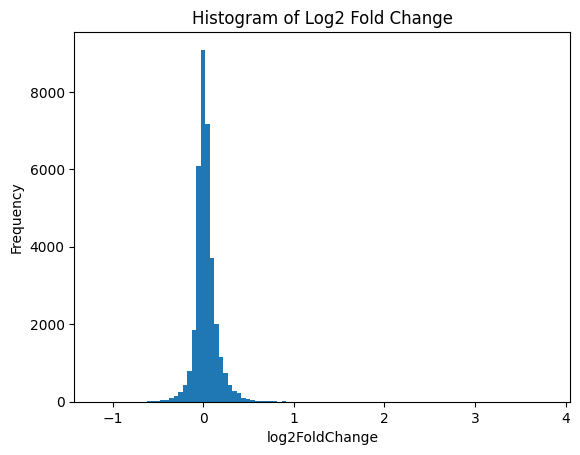

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('deseq2_results.txt', sep='\t')

# Drop missing values in Log2FoldChange
log2fc = df["log2FoldChange"].dropna()

# Plot histogram
plt.figure()
plt.hist(log2fc, bins=100)
plt.xlabel("log2FoldChange")
plt.ylabel("Frequency")
plt.title("Histogram of Log2 Fold Change")
plt.show()

**SECTION-4: GENE SET ENRICHMENT ANALYSIS**

This is a type of functional enrichment analysis known as a Functional Class Scoring (FCS) method. It does not require any manual pre-selection of a gene list - which means you don't have to filter by p-value or log2 fold change. All you have to do is sort all the genes in descending order based on a score derived from the log2 fold change value and the p-value.

ranking score = -log10(p.adj) x log2 fold change

Make sure that you're using the gene names for enrichment analysis!

Read this article for a detailed understanding of GSEA - *A. Subramanian, P. Tamayo, V.K. Mootha, S. Mukherjee, B.L. Ebert, M.A. Gillette, A. Paulovich, S.L. Pomeroy, T.R. Golub, E.S. Lander, & J.P. Mesirov, Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles, Proc. Natl. Acad. Sci. U.S.A. 102 (43) 15545-15550, https://doi.org/10.1073/pnas.0506580102 (2005).*

Read this article to understand the different types of pathway analysis techniques - *Nguyen, TM., Shafi, A., Nguyen, T. et al. Identifying significantly impacted pathways: a comprehensive review and assessment. Genome Biol 20, 203 (2019). https://doi.org/10.1186/s13059-019-1790-4*

In [15]:
!pip install gseapy
from gseapy.plot import gseaplot
import gseapy as gp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 10.7 MB/s eta 0:00:00


In [12]:
# let's first map the gene names to the ensembl IDs
deseq_df = pd.read_csv('deseq2_results.txt', sep='\t')
annot_df = pd.read_csv('Human.GRCh38.p13.annot.tsv', sep='\t')

IDs_symbols = annot_df[['GeneID', 'Symbol']]
deseq_df = deseq_df.merge(IDs_symbols, on='GeneID')
print(deseq_df)

          GeneID      baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0      100287102      5.092575        0.016078  0.097038  0.165686  0.868404   
1         653635    340.128546        0.073387  0.084328  0.870257  0.384160   
2      102466751     10.641487        0.050246  0.091067  0.551745  0.581123   
3      107985730     37.467768       -0.021137  0.037813 -0.558978  0.576177   
4      100302278     11.360831       -0.028297  0.052599 -0.537981  0.590590   
...          ...           ...             ...       ...       ...       ...   
34950       4541  16987.227641        0.009130  0.049748  0.183529  0.854383   
34951       4556   1659.844181        0.011706  0.052513  0.222915  0.823601   
34952       4519  85620.757712       -0.009840  0.038680 -0.254387  0.799196   
34953       4576     61.896159       -0.005160  0.063013 -0.081880  0.934742   
34954       4571   1172.924609        0.012171  0.053729  0.226531  0.820788   

           padj       Symbol  
0      0

/tmp/ipython-input-3428764748.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv('Human.GRCh38.p13.annot.tsv', sep='\t')


In [14]:
deseq_df['Rank'] = -np.log10(deseq_df.padj)*deseq_df.log2FoldChange
gsea_input = deseq_df[['Symbol', 'Rank']]
gsea_input = gsea_input.sort_values('Rank', ascending = False).reset_index(drop = True)
gsea_input = gsea_input.dropna()
gsea_input

,Symbol,Rank
0,LTF,11.195444
1,C1orf87,3.896787
2,PODN,3.604495
3,SLC47A2,3.381775
4,LINC01411,2.981094
...,...,...
26140,CSF3,-1.394626
26141,LOC107986020,-1.564287
26142,RN7SL3,-2.059540
26143,LOC105369559,-3.401487


In [18]:
# run this to see all available gene sets
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CM4AI_U2OS_Protein_Localization_Assemblies',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'Carcinogenome',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'ClinVar_2025',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popul

In [16]:
pre_res = gp.prerank(rnk = gsea_input, gene_sets = 'KEGG_2021_Human', seed = 6, permutation_num = 100)

out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

2026-02-15 11:17:53,161 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,Ribosome biogenesis in eukaryotes,0.010874,-0.872682,-2.075977
1,Ribosome,0.021747,-0.847725,-2.013411
2,Autoimmune thyroid disease,0.052865,0.932401,1.590923
3,Antigen processing and presentation,0.064429,0.910454,1.547762
4,Systemic lupus erythematosus,0.069385,0.937319,1.602909
...,...,...,...,...
297,Base excision repair,1.000000,0.272677,0.445149
298,Homologous recombination,1.000000,-0.385972,-0.744815
299,Collecting duct acid secretion,1.000000,-0.326372,-0.680038
300,Mismatch repair,1.000000,-0.524875,-0.999400


Using this table, we can generate a few different plots. We will discuss that later.